In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

## DRR Generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

### Modes

`DiffDRR` operates in two modes:

1. Rendering mode
2. Optimization mode

#### Rendering mode

*Rendering mode* is used for simulating an X-ray from a particular angle. To do this, pass the viewing angle an instance of the DRR module:

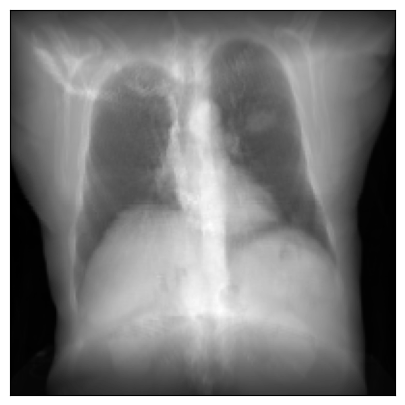

In [ ]:
# Read in the volume
volume, spacing = load_example_ct()

# Get parameters for the detector
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
detector_kwargs = {
    "sdr"   : 300.0,
    "theta" : torch.pi,
    "phi"   : 0,
    "gamma" : torch.pi / 2,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}

# Make the DRR
drr = DRR(volume, spacing, height=200, delx=4.0).to("cuda" if torch.cuda.is_available() else "cpu")
img = drr.project(**detector_kwargs)
ax = plot_drr(img, ticks=False)
plt.show()

#### Optimization mode

*Optimization mode* is used to integrate `DiffDRR` in optimization schemes. To use this mode, pass the viewing angle as a tensor (shape: `batch_size, 7`) during initialization.

This mode offers the following benefits:
1. The viewing angle are stored as module parameters that can be optimized with any differentiable loss function.
2. This mode supports batched DRR synthesis (simulating X-rays from multiple viewing angles at once)
3. The viewing angle parameters don't need to be passed each time.

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
params = torch.tensor([list(detector_kwargs.values())])  # shape: (batch_size, 7)
drr = DRR(
    volume,
    spacing,
    height=200,
    delx=4.0,
    params=params,  # Pass parameters to the constructor to initialize in optimization mode
).to("cuda" if torch.cuda.is_available() else "cpu")

%timeit drr()

34.9 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Sparse rendering

You can also render random sparse subsets of the pixels in a DRR. This is useful for speeding up registration tasks.

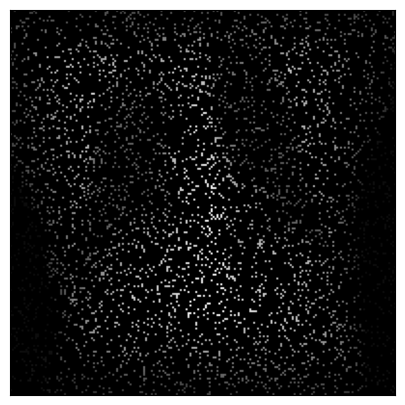

In [ ]:
# Make the DRR with 10% of the pixels
drr = DRR(
    volume,
    spacing,
    height=200,
    delx=4.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,     # Map rendered pixels back to their location in true space, 
                      # Useful for plotting, but can be disabled if using MSE as a loss function
    params=params
).to(device="cuda" if torch.cuda.is_available() else "cpu")
img = drr()
ax = plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr()

7.75 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Gradients

Gradients of input parameters are computable with autograd if the DRR is computed in `optimization_mode`.

In [ ]:
torch.autograd.set_detect_anomaly(True)

img.mean().backward(retain_graph=True)
drr.sdr.grad, drr.rotations.grad, drr.translations.grad

(tensor([[-16.4048]], device='cuda:0'),
 tensor([[  197.6467,  -162.0464, -1394.5438]], device='cuda:0'),
 tensor([[ 76.8212, -31.0211,  -3.4713]], device='cuda:0'))

## Try the M1 GPU

Certain PyTorch functions have not yet been ported :(

In [ ]:
#|eval: False

# Make DRR
drr = DRR(volume, spacing, height=200, delx=1.4e-2).to("mps", torch.float32)
img = drr.project(**detector_kwargs)
plot_drr(drr)
plt.show()